## TODO

- [ ] test & update code
- [ ] new viz methods
- [ ] replace WebPPL refs with Pyro

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import pyro
import pyro.distributions as dist
pyro.enable_validation()

import sys; sys.path.append('..')
from pyro_webppl import (
    flip, pflip, repeat, memoize, 
    factor, cond_var, condition, expectation, 
    Infer, viz, viz_heatmap)

# Intro

<!--
mht: some similar ideas (and examples) are presented in occams razor chapter. make sure the division of labor is good.

ndg: after moving earlier in the book, some major revisions are in order:
  -remove or move+shorten the spinning coin stuff, which is mostly about cogitive models and then bda of cognitive models.
  -start with the existing simple models illustrating the kinds of questions one asks with BDA and the metrics for answers (BF, CI, etc)
  -then do a slightly more complex model: regression analysis.
  -then do BDA of cognitive models.
  -then do full tug-of-war example. needs to be cleaned up for clarity.

  -consider splitting into two chapters, with model selection stuff in part 2 occurring after occam's razor chapter. LMER models also make more sense there....
  -need to add some discussion of CIs.
  -Include illustrations of each point with regression models, as wel as simpler models that are there now.
  -include some discussion of contamination models and other stadard BDA model idioms.
  -most of the editor.put and .get things are unecessary?
  -the data munging is pretty crazy. use more standard DF library?
  -dist.MAP() seems suspect....
  -posterior predictive checks are not very well explained -- need to show an example of a good result, not just the bad one. (also having only two data points makes it hard to understand the scatter plot...)

  -a bit of advanced discussion? eg time varrying data, optional stopping?
-->

Inference by conditioning a generative model is a basic building block of Bayesian statistics.
In cognitive science this tool can be used in two ways.
If the generative model is a hypothesis about a person's model of the world, then we have a Bayesian *cognitive model* -- the main topic of this book.

If the generative model is instead the scientist's model of how the data are generated, then we have *Bayesian data analysis*.
Bayesian data analysis can be an extremely useful tool to us as scientists, when we are trying to understand what our data mean about psychological hypotheses.

This can become confusing: a particular modeling assumption can be something we hypothesize that people assume about the world, or can be something that we as scientists want to assume (but don't assume that people assume).
A pithy way of saying this is that we can make assumptions about "Bayes in the head" (Bayesian cognitive models) or about "Bayes in the notebook" (Bayesian data analysis).

## Aside: Spinning coins

Coins, in their production, have a number of physical dimensions along which they vary.
These idiosyncracies have no impact on the behavior of a coin when flipped.
Flipping, it turns out, cross-cuts certain dimensions, and the probability that any modern coin in production will land on heads when flipped is roughly 0.5.

It turns out spinning a coin is quite different.
The heterogeneity of individual coins can be seen in their behavior when spun: The probability that any given coin will land on heads after being *spun* is not 0.5.
The probability that a given coin will spin to heads depends in complicated ways upon the idiosyncracies of that coin.

## People's models of coins

Imagine I give you a coin, and want you to estimate the probability it will spin to heads.
Given what you know, the most reasonable prior belief is to expect *any* probability of the coin spinning to heads.
This can be captured in a uniform prior on $p$, the probability that a coin when spun will land on heads: `pyro.sample('p', dist.Uniform(0,1))`.

You conduct an experiment.
You spin the coin 20 times.
Fifteen out of these 20 times, the coin spins to heads.

Let's say you can win \$10 if you can predict the next coin flip (heads or tail).
What would you predict (Heads or Tails)?

Let's consider a slightly more challenging question.
You pay me \$10 if you are wrong, but if you are correct, I pay you.
How much do you propose you take from me, should you guess correctly?

Imagine you demand \$10 for being correct.

(If you guess correctly, you win \$10. If you guess incorrectly, you lose \$10.)  TODO - escape markdown

If we believed the coin would spin to Heads or Tails with equal probability, this is a fair betting scheme.
But if we believe the coin is biased to spin to one side or the other with greater than 50% probability, you should offer me more than \$10, given that you get to choose which side counts as winning for you.


Expected value = 0.7288342714309692


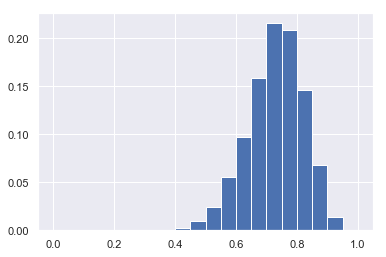

In [5]:
def observer_model():
    p = pyro.sample('p', dist.Uniform(0, 1))
    coin_spinner = dist.Binomial(20, p)
    pyro.sample('heads_coins', coin_spinner, obs=torch.Tensor([15.]))
    return p

posterior_beliefs = Infer(observer_model, posterior_method="rejection", num_samples=5000, draw_samples=True)
print("Expected value = {}".format(expectation(posterior_beliefs)))
viz(posterior_beliefs, plot_args={'bins': 20, 'range': [0, 1]})

The model above is a hypothesis about how a person updates her prior beliefs about the probability of a coin being spun to heads, upon conducting 20 trials of a spinning experiment.
We can use this model to make predictions about other kinds of questions we could then ask the observer.
For instance, let's take up the bet of whether or not the *next spin* will go to heads.
Also, consider if you were to make 10 more spins: How many of them would go to heads?

Expected value of next outcome = 0.7309373021125793


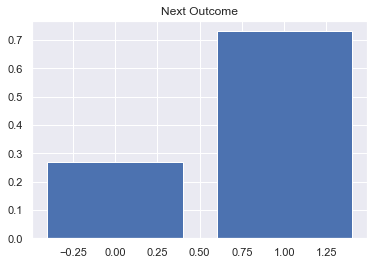

Expected value of next 10 outcomes = 7.279888153076172


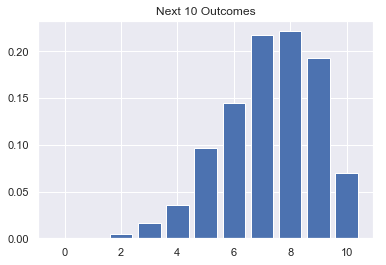

In [15]:
def observer_model():
    p = pyro.sample('p', dist.Uniform(0, 1))
    coin_spinner = dist.Binomial(20, p)
    pyro.sample('heads_coins', coin_spinner, obs=torch.Tensor([15.]))
    
    next_outcome = dist.Bernoulli(p).sample()
    next_ten_outcomes = dist.Binomial(10, p).sample()
    
    return next_outcome, next_ten_outcomes

next_outcome_post = Infer(
    lambda: observer_model()[0], 
    posterior_method="rejection", num_samples=5000
)
print("Expected value of next outcome = {}".format(expectation(next_outcome_post)))
viz(next_outcome_post, title='Next Outcome')

next_ten_outcomes_post = Infer(
    lambda: observer_model()[1], 
    posterior_method="rejection", num_samples=5000
)
print("Expected value of next 10 outcomes = {}".format(expectation(next_ten_outcomes_post)))
viz(next_ten_outcomes_post,title='Next 10 Outcomes')

A model can be used to make predictions about different tasks.
Models are useful in this way: *They are tools for thinking through the implications of hypotheses*.
In this model, we formalized the hypothesis that people reason about the weight of a coin by assuming the outcomes they observe (i.e., the 15 out of 20 heads) are independent results of spinning the coin, which has some unknown proclivity to be spun to heads.
This reasoning supports responses to other types of questions such as "How likely is the next spin to land on heads?".
We use the same model to see what our hypothesis predicts given this new question.
Each question could be thought of as a different experiment you could run to test the same hypothesis/model.

Above, we have one hypothesis about a person thinking about the spinning coins experiments.
There are other hypotheses we could make about this experiment.
Rather than have uniform prior beliefs, maybe people port their knowledge of flipping behavior, and believe with some probability that spinning coins will behave similarly: There is a reasonable chance that spinning coins is as random as flipping coins.
But if that belief is not well supported, the observer can accommodate that by inferring that the behavior of spinning coins is quite different than that of flipping coins (as I explained above). If the observer believes the behavior of spinning coins is *different* than that of flipping coins, the model takes on the form of the model above: uniform beliefs about `p`.
We'll call the new model that assumes people's expectations about spinning behavior are influenced by their knowledge of flipping behavior (namely, the observer believes the behavior of spinning coins could be the *same* as that of flipping coins) the `skeptical_model` because it is, in a way, skeptical of the story I told you above about spinning coins.

In [ ]:
skeptical_model = function(){
  same_as_flipping = flip(0.5)
  p = same_as_flipping ? 0.5 : dist.Uniform(0, 1)
  coin_spinner = dist.Binomial({n:20, p:p})
  observe(coin_spinner, 15)
  return {
    same_as_flipping: same_as_flipping,
    p: p,
    next_outcome: flip(p),
    next_ten_outcomes: dist.Binomial(p, 10)
  }
}

opts = {method: "rejection", samples: 5000}
posterior_beliefs = Infer(opts, skeptical_model)
viz_marginals(posterior_beliefs)

The predictions are subtly different.
`skeptical_model` pulls the predictions more towards 50/50.
Why is that?

One way to understand this model is to examine the prior.
Try commenting out the `observe` statement and looking at the predictions.
Examine the plots for `p` and `next_ten_outcomes`.
The prior favors `p` around 0.5 and `next_ten_outcomes` to be about 5.
This is because we assume there is a `0.5` probability that the behavior is the same as flipping (`same_as_flipping = flip(0.5)`).
If indeed it is the same as flipping, `p = 0.5` and the resulting `next_ten_outcomes` would be biased towards expecting around 5 heads.
If it's not the same as flipping, then the predictions are the same as the `observer_model`.
The prior is a mixture of these two possibilities.

## Scientists' models of people

The above models instantiate different hypotheses about the coin spinning experiemnts, and  make different predictions about what people will do in this situation.
We could recruit volunteers, run experiments in a laboratory, and record our participants' responses.
But, how are we to decide which model is better?

One way to begin to address this would be to ask ourselves: How much do we believe in each model?
At this point, both models seem totally reasonable to me: I would say I believe in each of them equally.
Okay, then how are we supposed to update these beliefs?

Since each model makes predictions about what we should observe in an experiment, we already know how to update our beliefs in these models based on the experimental data we observed.
We simply `observe` the data, assuming that it was generated by the better model.


```python
scientist_model = function(){

  the_better_model = flip(0.5) ? observer_model : skeptical_model

  observe(the_better_model, experimental_data)

  return the_better_model
}
```

Note that we are assuming "the better model" generated the data because that is how we are defining what "better" is (i.e., it is a better explanation of how the data were generated).

We have now instantiated our scientific process as a probabilistic program, doing Bayesian inference.
This is the foundation of Bayesian data analysis.

We must specify prior beliefs about which is the better model in this case we say that we don't have any bias in our prior beliefs: each model is equally likely to be better *a priori*.
We then seek to update our beliefs about which is the better model, by observing `experimental_data`, assuming that it came from `the_better_model`.

Imagine we ran the "predict the next 10" experiment with 20 participants, and observed the following responses:


<!--
to generate expt data:
fair_unfair_model = function(){
  isFair = flip(0.5)
  weight = isFair ? 0.5 : dist.Uniform(0, 1)
  coinFlipper = dist.Binomial({n:20, p:weight})
  observe(coinFlipper, 15)
  return dist.Binomial(weight, 10)
}
opts = {method: "rejection", samples: 5000}
posterior_beliefs = Infer(opts, fair_unfair_model)
repeat(20, function(){sample(posterior_beliefs)})
-->

```python
experimental_data = [9,8,7,5,4,5,6,7,9,4,8,7,8,3,9,6,5,7,8,5]
```

Look again at the model predictions for `next_ten_outcomes` for the two models above.
Which model do you think is better?

We are now ready to put all the pieces together:

In [ ]:
###fold:
opts = {method: "rejection", samples: 5000}
print("generating observer model predictions")
observer_model =  Infer(opts, function(){
  p = dist.Uniform(0, 1)
  coin_spinner = dist.Binomial({n:20, p:p})
  observe(coin_spinner, 15)
  return dist.Binomial(p, 10)
})
viz(observer_model)

print("generating skeptical model predictions")
skeptical_model =  Infer(opts, function(){
  same_as_flipping = flip(0.5)
  p = same_as_flipping ? 0.5 : dist.Uniform(0, 1)
  coin_spinner = dist.Binomial({n:20, p:p})
  observe(coin_spinner, 15)
  return dist.Binomial(p, 10)
})
###
viz(skeptical_model)

experimental_data = [9,8,7,5,4,5,6,7,9,4,8,7,8,3,9,6,5,7,8,5]

# package the models up in an Object (for ease of reference)
modelObject = {observer_model: observer_model, skeptical_model: skeptical_model}

scientist_model = function(){
  the_better_model_name = flip(0.5) ? "observer_model" : "skeptical_model"
  the_better_model = modelObject[the_better_model_name]
  map(function(d){ observe(the_better_model, d) }, experimental_data)
  return {betterModel: the_better_model_name}
}

model_posterior = Infer({method: "enumerate"}, scientist_model)

viz(model_posterior)

What is the result of the model comparison model (which model is preferred)?

Examine the predictions of each individual model and look at the `experimental_data`.
The differences in model predictions are subtle.
What parts of the experimental data are leading to the `scientist_model` preferring one model over another?

### Closing remarks to Prologue

We've just walked through a complete example of formalizing a cognitive model (i.e., a hypothesis) in a probabilistic program and building a probabilistic program to decide among competing hypotheses.
The rest of this chapter will be focused on examining each part in more detail.

<!--
#### Introduce a parameter into FairUnfair?
-->

# Learning about a hypothesis

Bayesian data analysis is a general purpose data analysis approach for making explicit hypotheses about the generative process behind the experimental data (i.e., how was the experimental data generated? e.g., the hypothesis that data from two experimental conditions came from two different distributions).
After making explicit hypotheses, Bayesian inference can be used to *invert* the model: go from experimental data to updated beliefs about the hypotheses.

For further reading on Bayesian data analysis: see [Lee & Wagenmakers (2013)](https://bayesmodels.com/),
[Kruschke (2014)](https://sites.google.com/site/doingbayesiandataanalysis/), and [Gelman et al. (2014)](http://www.stat.columbia.edu/~gelman/book/).

## Parameters and predictives

Models have parameters.
Parameters can be of theoretical interest or not (so-called, nuisance parameters).
Learning about a hypothesis involves inferences based on the values of parameters.
For example, you want to find out how likely it is that Candidate A will win an election.
To do this, you try to estimate the proportion of eligible voters in the United States who will vote for Candidate A in the election.

Parameters are in general unobservable (or, "latent").
Trying to estimate how many (voting age, likely to vote) people prefer Candidate A vs. Candidate B would require asking over 100 million people (it's estimated that about 130 million people voted in the US Presidential Elections in 2008 and 2012).
It's impractical to measure the whole distribution.
Instead, what is done is measuring a sample (maybe we ask 1000 people), and use that to make inference about the "true population proportion" (an unobservable parameter).

Bayes’ rule provides a bridge between the unobserved parameters of models and the observed data.
We can update our beliefs about parameters from data.
Additionally, the "Bayes bridge" can go from parameters to data: we can use our updated beliefs about a parameter to make predictions about future data sets.

For a given Bayesian model (together with data), there are four conceptually distinct distributions of interest:

For parameters, we have priors and posteriors:

+ The *prior distribution over parameters* captures our initial state of knowledge (or, our beliefs) about the values that the latent parameters could have.
+ The *posterior distribution over parameters* captures what we know about the latent parameters having updated our beliefs with the evidence provided by data.

We can run either the prior or the posterior model forward, and have it make predictions about data sets:

+ The *prior predictive distribution* tells us what data to expect, given our model and our initial beliefs about the parameters.
The prior predictive is a distribution over data, and gives the relative probability of different *observable* outcomes before we have seen any data.
+ The *posterior predictive distribution* tells us what data to expect, given the same model we started with, but with beliefs that have been updated by the observed data. The posterior predictive is a distribution over data, and gives the relative probability of different observable outcomes, after some data has been seen.

Loosely speaking, *predictive* distributions are in "data space" and *parameter* distributions are in "latent parameter space".

## A simple illustration

Here, we explore the result of an experiment with 20 trials and binary outcomes (e.g., asking people if they'll vote for Candidate A or Candidate B, ...).
Note that is the same model as the "observer_model" above.

In [ ]:
# observed data
k = 1 # number of people who support candidate A
n = 20  # number of people asked

model = function() {

   # true population proportion who support candidate A
   p = dist.Uniform(0, 1)

   # Observed k people support "A"
   # Assuming each person's response is independent of each other
   observe(dist.Binomial({p : p, n: n}), k)

   # predict what the next n will say
   posterior_predictive = dist.Binomial(p, n)

   # recreate model structure, without observe
   prior_p = dist.Uniform(0, 1)
   prior_predictive = dist.Binomial(prior_p, n)

   return {
       prior: prior_p, prior_predictive : prior_predictive,
       posterior : p, posterior_predictive : posterior_predictive
    }
}

opts = {method: "rejection", samples: 2000}
posterior = Infer(opts, model)

viz_marginals(posterior)


Try to interpret each plot, and how they relate to each other.
Why are some plots densities and others bar graphs?
Understanding these ideas is a key to understanding Bayesian analysis.
Check your understanding by trying other data sets, varying both `k` and `n`.

<!-- 2. Try different priors on `p`, by changing `p = dist.Uniform(0, 1)` to `p = beta(10,10)`, `beta(1,5)` and `beta(0.1,0.1)`. Use the figures produced to understand the assumptions these priors capture, and how they interact with the same data to produce posterior inferences and predictions.

3. Predictive distributions are not restricted to exactly the same experiment as the observed data, and can be used in the context of any experiment where the inferred model parameters make predictions. In the current simple dist.Binomial setting, for example, predictive distributions could be found by an experiment that is different because it has `n' != n` observations. Change the model to implement an example of this.
 -->

## Posterior prediction and model checking

The posterior predictive distribution describes what data you should expect to see, given the model you've assumed and the data you've collected so far.
If the model is a good description of the data you've collected, then the model shouldn't be surprised if you got the same data by running the experiment again.
That is, the most likely data for your model after observing your data should be the data you observed.

It's natural then to use the posterior predictive distribution to examine the descriptive adequacy of a model.
If these predictions do not match the data *already seen* (i.e., the data used to arrive at the posterior distribution over parameters), the model is descriptively inadequate.

Imagine you're a developmental psychologist, piloting a two-alternative forced choice task on young children.
(Just for fun, let's pretend it's a helping study, where the child either chooses to help or not help a confederate in need.)
You have two research assistants that you send to two different preschools to collect data.
You got your first batch of data back today: For one of your research assistants, 10 out of 10 children tested helped the confederate in need. For the other research assitant, 0 out of 10 children tested helped.

We'll use the `editor.put()` function to save our results so we can look at the them in different code boxes.

In [ ]:
# "Kids who help" in 2 experiments
k1 = 0
k2 = 10

# Number of kids in 2 experiments
n1 = 10
n2 = 10

def model():

    # "true effect in the population"
    p = dist.Uniform(0, 1)

    # observed data from 2 experiments
    observe(dist.Binomial(p, n1), k1)
    observe(dist.Binomial(p, n2), k2)

    # posterior prediction
    posterior_predictive1 = dist.Binomial(p, n1)
    posterior_predictive2 = dist.Binomial(p, n2)

    return {
        'parameter': p,
        'predictive': {
            'predictive1': posterior_predictive1,
            'predictive2': posterior_predictive2
        }
    }

opts = {
    method: "MCMC", 
    callbacks: [editor.MCMCProgress()],
    samples: 20000, 
    burn: 10000,
}

posterior = Infer(opts, model)

posterior_predictive = marginalize(posterior, lambda x: x['predictive'])
# save results for future code boxes
editor.put("posterior_predictive", posterior_predictive)

parameter_posterior = marginalize(posterior, lambda x: x['parameter'])
viz_density(parameter_posterior, {bounds: [0, 1]})


Looks like a reasonable posterior distribution.

How does the posterior predictive look?

In [ ]:
posterior_predictive = editor.get("posterior_predictive")
viz(posterior_predictive)

This plot will be a heat map because our posterior predictive distributions is over two dimensions (i.e., future data points collected by experimenter 1 and experimenter 2).
The intensity of the color represents the probability.

How well does it recreate the observed data?
Where in this 2-d grid would our observed data land?

Another way of visualizing the model-data fit is to examine a scatterplot.
Here, we will plot the "Maximum A-Posteriori" value as a point-estimate of the posterior predictive distribution.
If the data is well predicted by the posterior predictive (i.e., the model is able to accommodate the data well), it would fall along the y = x line.

In [ ]:
k1 = 0, k2 = 10
posterior_predictive = editor.get("posterior_predictive")
posterior_predictive_MAP = posterior_predictive.MAP().val
viz_scatter([
   {model: posterior_predictive_MAP.predictive1, data: k1},
   {model: posterior_predictive_MAP.predictive2, data: k2}
])


How well does the posterior predictive match the data?
What can you conclude about the parameter `p`?

<!-- **TODO: This doesn't yet quite make the point about what a model check is. Show example of typical posterior predictive scatter plot?**
 -->
<!--
### Exercises 2

1.  What do you conclude about the descriptive adequacy of the model, based on the relationship between the observed data and the posterior predictive distribution? Recall the observed data is `k1 = 0 n1 = 10` and  `k2 = 10 n2 = 10`.

2. What can you conclude about the parameter `theta`?
-->

<!--
Basics from [PPAML school](http://probmods.github.io/ppaml2016/chapters/5-data.html)
-->

# Comparing hypotheses

In the above examples, we've had a single data-analysis model and used the experimental data to learn about the parameters of the models and the descriptive adequacy of the models.
Often as scientists, we are in fortunate position of having multiple, distinct models in hand, and want to decide if one or another is a better description of the data.
Indeed, we saw an example with the spinning coins when we decided whether `"observer_model"` or  `"skeptical_model"` was a better explanation of some data.

In that example, model comparison was shown a special case of learning about the parameters of a model.
In that case, we defined an uber model (`scientist_model`), that had a binary decision parameter that we wanted to learn about (which one of the models was better).
We did this by having a binary decision variable gate between which of our two models we let generate the data.
We then go backwards (performing Bayesian inference) to decide which model was more likely to have generated the data we observed.

We take the same approach here, articulating a simple data analysis model for model comparison.
We observe some number of binary outcomes and want to decide if the pattern we see is random or not (e.g., to see if the helping behavior "is systematic" [assuming we've figured out the weird stuff going on with the experimenters before]).
This model mimics a simple cognitive model for subjective randomness, which we will explore in another chapter of this book on Subjective Randomness.

Formally, a "true random" pattern would be generated by a coin with probability of doing one or other binary outcome as 0.5 (a fair coin) a "non random" pattern would be generated by a trick coin.
We run into our first complication: A fair coin is simple to define: `Bernoulli({p: 0.5})`, but how can we treat a trick coin?
For purposes of scientific hypothesis testing, a trick coin is formalized as a coin with some *unknown* weight:

```python
p = dist.Uniform(0,1)
Bernoulli({p: p})
```

Using this to now compare models:

In [ ]:
k = 7, n = 20

compare_models = function() {

  # binary decision variable for which hypothesis is better
  x = flip(0.5) ? "simple" : "complex"
  p = (x == "simple") ? 0.5 : dist.Uniform(0, 1)

  observe(dist.Binomial({p: p, n: n}), k)

  return {model: x}
}

opts = {method: "rejection", samples: 2000}
print("We observed " + k + " successes out of " + n + " attempts")
model_posterior = Infer(opts, compare_models)
viz(model_posterior)

This model is an example from the classical hypothesis testing framework.
We consider a model that fixes one of its parameters to a pre-specified value of interest (here $\mathcal{H_0} : p = 0.5$).
This is sometimes referred to as a *null hypothesis*.
The other model says that the parameter is free to vary.
In the classical hypothesis testing framework, we would write: ${H_1} : p \neq 0.5$.
With Bayesian hypothesis testing, we must be explicit about what $p$ is (not just what p is not), so we write ${H_1} : p \sim \text{Uniform}(0, 1) $.

One might have a conceptual worry: Isn't the second model just a more general case of the first model?
That is, if the second model has a uniform distribution over `p`, then `p: 0.5` is included in the second model.
This is what's called a *nested model*.

Shouldn't the more general model always be better?
If we're at a track, and you bet on horse A, and I bet on horse A and B, aren't I strictly in a better position than you?
The answer is no, and the reason has to do with our metric for winning.
Intuitively, we don't care whether your horse won or not, but how much money you win.
How much money you win depends on how much money you bet, and the rule is, when we go to track, we have the same amount of money.

In probabilistic models, our money is probabilities. Each model must allocate its probability so that it sums to 1.
So my act of betting on horse A and horse B actually requires me to split my money (say, betting 50 / 50 on each).
On the other hand, you put all your money on horse A (100 on A, 0 on B).
If A wins, you will gain more money because you put more money down.

This idea is called the principle of parsimony or Occam's razor, and will be discussed at length later in this book.
For now, it's sufficient to know that more complex models will be penalized for being more complex, intuitively because they will be diluting their predictions.
At the same time, more complex models are more flexible and can capture a wider variety of data (they are able to bet on more horses, which increases the chance that they will win some money).
Bayesian model comparison lets us weigh these costs and benefits.

## Bayes' factor

What we are plotting above are **posterior model probabilities**.
These are a function of the marginal likelihoods of the data under each hypothesis and the prior model probabilities (here, defined to be equal: `flip(0.5)`).
Sometimes, scientists feel a bit strange about reporting values that are based on prior model probabilities (what if scientists have different priors as to the relative plausibility of the hypotheses?) and so often report the ratio of marginal likelihoods, a quantity known as a *Bayes Factor*.

Let's compute the Bayes' Factor, by computing the likelihood of the data under each hypothesis.

In [ ]:
k = 7, n = 20

simple_likelihood = np.exp(dist.Binomial(0.5, n).score(k))

complex_model = Infer({method: "forward", samples: 10000}, function(){
  p = dist.Uniform(0, 1)
  return dist.Binomial(p, n)
})
complex_likelihood = np.exp(complex_model.score(k))

bayes_factor_01 = simple_likelihood / complex_likelihood
bayes_factor_01


How does the Bayes Factor in this case relate to posterior model probabilities above?

## Savage-Dickey method

For this example, the Bayes factor can be obtained by integrating out the model parameter (using `Infer` with `{method: "forward"}`).
However, it is not always easy to get good estimates of the two marginal probabilities.
It turns out, the Bayes factor can also be obtained by considering *only* the more complex hypothesis ($\mathcal{H}_1$).

What you do is look at the distribution over the parameter of interest (here, $p$) at the point of interest (here, $p = 0.5$).
Dividing the probability density of the posterior by the density of the prior (of the parameter at the point of interest) also gives you the Bayes Factor!

This perhaps surprising result was described by Dickey and Lientz (1970), and they attribute it to Leonard "Jimmie" Savage.
The method is called the *Savage-Dickey density ratio* and is widely used in experimental science.

We would use it like so:

In [1]:
k = 7, n = 20

complex_model_prior = Infer({method: "forward", samples: 10000}, function(){
  p = dist.Uniform(0, 1)
  return p
})

complex_model_posterior = Infer({method: "rejection", samples: 10000}, function(){
  p = dist.Uniform(0, 1)
  observe(dist.Binomial({p: p, n: n}), k)
  return p
})

savage_dickey_denominator = expectation(complex_model_prior, lambda x: np.abs(x - 0.5) < 0.05)
savage_dickey_numerator = expectation(complex_model_posterior, lambda x: np.abs(x - 0.5) < 0.05)
savage_dickey_ratio = savage_dickey_numerator / savage_dickey_denominator
print( savage_dickey_ratio )


SyntaxError: invalid syntax (<ipython-input-1-370799a7d653>, line 3)

(Note that we have approximated the densities by looking at the expectation that $p$ is within $0.05$ of the target value $p=0.5$.)

<!--
**Discuss difficulties with model comparison? (harmonic mean estimators, mcmc for likelihoods)**
-->

<!-- # Linking functions
 -->

# Example: Linear regression and tug of war

One of the virtues of Bayesian data analysis is its ability to interface with Bayesian models of cognition in a natural way.
Bayesian cognitive models are formalizations of hypotheses about cognition, which we then can test with an experiment.
We can contrast our rich Bayesian cognitive models with more standard models from data science, like linear regression, and evaluate them all using Bayesian data analysis.

Regression is the workhorse of data science.
Regression models are useful in situations when you have (1) data and (2) some (potentially vague) hypotheses about how variables relate to each other (e.g., that demographics might predict political party affiliation [in some unspecified way]).
In psychology and many other behavioral sciences, experiments are often constructed with discrete/categorical manipulations (e.g., measuring processing time of words vs. pseudowords).
The question "is A greater than B?" (is the processing time of words faster than the processing time of pseudowords?) can be answered using a regression model.

To explore a Bayesian linear regression model, we will use data from the Tug-of-War experiment by @Gerstenberg2012.
Let's be good data scientists, and start by just taking a look at the data set, found in the `tow_data` variable (available in this page only).

In [ ]:
levels = function(a, lvl){ return _.uniq(_.map(a, lvl)) }

# display single row of the data frame
print(tow_data[0])
# display unique levels of "pattern" variable
print(levels(tow_data, "pattern"))
# display unique levels of "tournament" variable
print(levels(tow_data, "tournament"))
# display unique levels of "nWins" variable
print(levels(tow_data, "nWins"))
# display unique levels of "id" variable [participant id]
print(levels(tow_data, "id"))


The first line printed is a line from our data set: one participant on one trial.
We see that it has many different fields, including the trial number, their raw rating ("rating"), a normalized score ("ratingZ"), and information about the experimental condition.
Here, this was the condition "confounded evidence" in a "singles" tournament: here, the target player won 3 times against the same player (for a full list of the experimental conditions see @Gerstenberg2012 Tables 2 and 3).

The other lines show the unique values different variables can take on.

Let's plot the `ratingZ` variable (a normalized rating).

viz_hist(_.map(tow_data, "ratingZ"))

This distribution of ratings is from all trials, all participants, all experimental conditions.
We see that the ratings range from about -2 to 2.
The most likely ratings are one standard deviation above or below the mean, though some ratings are at the mean of 0.

## Single regression

Let's say we ran this experiment and hypothesized that the number of times the target character won (`"nWins"` in the data set) is a predictor of how participants' ratings of strength.
We'll formalize this in a Bayesian regression framework, where ratings of strength $r$ are a linear combination of a fixed intercept $\beta_0$ and weighted component of number of wins $\beta_1 *  n_{wins}$.

$y_{predicted} = \beta_0 + \beta_1 * n_{wins}$

Because we're in the business of building generative models, we will have to be explicit about how $y_{predicted}$ relates to the actual rating data we observed.
We make the standard assumption that the actual ratings are normally distributed around $y_{predicted}$, with some noise $\sigma$. [This is analagous to having "randomly distributed errors".]

$d \sim \mathcal{N}(y_{predicted}, \sigma)$

This is a model of our data.
As in cognitive models, we will put priors on the parameters: $\beta_0, \beta_1, \sigma$, and infer their likely values by conditioning on the observed data.

In [ ]:
# alternative proposal distribution for metropolis-hastings algorithm
uniform_kernel = function(prev_val) {
  return dist.Uniform({a: prev_val - 0.2, b: prev_val + 0.2})
}

singleRegression = function(){
  # parameters of a simple linear regression
  b0 = sample(dist.Uniform({a: -1, b: 1}), {drift_kernel: uniform_kernel})
  b1 = sample(dist.Uniform({a: -1, b: 1}), {drift_kernel: uniform_kernel})
  sigma = sample(dist.Uniform({a: 0, b: 2}), {drift_kernel: uniform_kernel})

  map(function(d){

    # linear regression formula
    predicted_y = b0 + d.nWins*b1

    observe(dist.Normal({mu: predicted_y, sigma: sigma}), d.ratingZ)

  }, tow_data)

  return {b0: b0, b1: b1, sigma: sigma}
}

num_samples = 2500
opts = { method: "MCMC", callbacks: [editor.MCMCProgress()],
             samples: num_samples, burn: num_samples/2 }

posterior = Infer(opts, singleRegression)

editor.put("singleRegression", posterior)

In [ ]:
posterior = editor.get("singleRegression")
viz_marginals(posterior)

The posteriors are somewhat noisy because we haven't taken that many samples.
We see that the intercept $\beta_0$ is around 0, which we might expect given that our data is normalized.
The slope weight $\beta_1$ is around 0.35, with relatively low variance around that.
The fact that it's very unlikely for $\beta_1$ to be 0 suggests that there is an effect of the number of times the actor has won in Tug of War on participants' judgments of the relative strength of that actor, as we might hope.
$\sigma$ is almost around 0.5, which seems a little bit high given that the full range of the response ratings is 4 (-2 to +2).

### Model criticism with posterior prediction

We can now critique the model by asking how well it would generate our data.
To do this, we look at the posterior predictive distribution.
There are 20 different experimental conditions (wins vs. loss, singles vs. doubles, and 4 - 6 different kinds of tournaments).
We want to examine our predictions for each of these conditions separately, so we rewrite the model slightly by mapping over each condition variable separately.

In [ ]:
merge = function(m, d){
  keys = _.keys(d)
  map(function(k){return {model: m[k], data: d[k], item:k} }, keys)
}

levels = function(a, lvl){ return _.uniq(_.map(a, lvl)) }

outcomes = levels(tow_data, "outcome")
tournaments = levels(tow_data, "tournament")
patterns = {
  single: levels(_.filter(tow_data, {tournament: "single"}), "pattern"),
  double: levels(_.filter(tow_data, {tournament: "double"}), "pattern")
}

# alternative proposal distribution for metropolis-hastings algorithm
uniform_kernel = function(prev_val) {
  return dist.Uniform({a: prev_val - 0.2, b: prev_val + 0.2})
}

singleRegression = function(){
  b0 = sample(dist.Uniform({a: -1, b: 1}), {drift_kernel: uniform_kernel})
  b1 = sample(dist.Uniform({a: -1, b: 1}), {drift_kernel: uniform_kernel})
  sigma = sample(dist.Uniform({a: 0, b: 2}), {drift_kernel: uniform_kernel})

  predictions = map(function(tournament){
    return map(function(outcome){
      return map(function(pattern){

        item_info = {pattern: pattern, tournament: tournament, outcome: outcome}
        item_data = _.filter(tow_data, item_info)

        # linear regression formula
        predicted_y = b0 + item_data[0]["nWins"]*b1

        map(function(d){ observe(dist.Normal({mu: predicted_y, sigma: sigma}), d.ratingZ)}, item_data)

        return [pattern + "_" + tournament + "_" + outcome, predicted_y]

      }, patterns[tournament]) # singles tournaments don't have all patterns
    }, outcomes)
  }, tournaments)

  # nasty data munging
  return _.fromPairs(_.flattenDepth(predictions, 2))
}

num_samples = 500
opts = { method: "MCMC", callbacks: [editor.MCMCProgress()],
             samples: num_samples, burn: num_samples/2 }

posterior = Infer(opts, singleRegression)

model_data_df = merge(posterior.MAP().val, towMeans)

viz_scatter(model_data_df)
editor.put('singleRegression', posterior)
editor.put('model_data_df', model_data_df)

In [ ]:
# Todo: have summary data include match schematics (Tables 2 & 3)
# or just include tables 2 and 3 from paper -->

###fold:
correlation = function(xs, ys) {
    mx = sum(xs)/xs.length,
        my = sum(ys)/ys.length
    num = sum(map2(function(x,y) { (x-mx) * (y-my)}, xs, ys))
    den = np.sqrt(sum(map(function(x) { (x-mx) * (x-mx)},xs))) *
        np.sqrt(sum(map(function(y) { (y-my) * (y-my)},ys)))
    return num/den
}
###

model_data_df = editor.get('model_data_df')

summary_data = map(function(x){
  return _.extend(x, {sq_err: np.pow(x.model-x.data, 2)})
}, model_data_df)

print("Mean squared error = " + listMean(_.map(summary_data, "sq_err")))

variance_explained = np.pow(correlation(_.map(summary_data, "data"), _.map(summary_data, "model")), 2)
print("Model explains " + np.round(variance_explained*100) + "% of the data")

viz_table(summary_data)

The simple linear regression does surprisingly well on this data set (at least at predicting the mean responses).
This is important to know; it provides a standard against which we can evaluate richer models.

At the same time, we observe in the posterior predictive scatterplot that not all the linear model is predicting certain symmetries that don't come out.
Why might that be?

## Mutiple regression

Now, some of the conditions has Alice winning against the same person, so maybe it's also important how many unique wins she has.

$y_{predicted} = \beta_0 + \beta_1 * n_{wins} + \beta_2 * wins_{unique}$

In [ ]:
###fold:
levels = function(a, lvl){ return _.uniq(_.map(a, lvl)) }

outcomes = levels(tow_data, "outcome")
tournaments = levels(tow_data, "tournament")
patterns = {
  single: levels(_.filter(tow_data, {tournament: "single"}), "pattern"),
  double: levels(_.filter(tow_data, {tournament: "double"}), "pattern")
}

# alternative proposal distribution for metropolis-hastings algorithm
uniform_kernel = function(prev_val) {
  return dist.Uniform({a: prev_val - 0.2, b: prev_val + 0.2})
}
###

multiple_regression = function(){
  b0 = sample(dist.Uniform({a: -1, b: 1}), {drift_kernel: uniform_kernel})
  b1 = sample(dist.Uniform({a: -1, b: 1}), {drift_kernel: uniform_kernel})
  b2 = sample(dist.Uniform({a: -1, b: 1}), {drift_kernel: uniform_kernel})
  sigma = sample(dist.Uniform({a: 0, b: 2}), {drift_kernel: uniform_kernel})


  predictions = map(function(tournament){
    return map(function(outcome){
      return map(function(pattern){

        item_info = {pattern: pattern, tournament: tournament, outcome: outcome}
        item_data = _.filter(tow_data, item_info)

        # linear equation
        predicted_y = b0 + item_data[0]["nWins"]*b1 + item_data[0]["nUniqueWins"]*b2

        map(function(d){ observe(dist.Normal({mu: predicted_y, sigma: sigma}), d.ratingZ) }, item_data)

        return [pattern + "_" + tournament + "_" + outcome, predicted_y]

      }, patterns[tournament]) # singles tournaments don't have all patterns
    }, outcomes)
  }, tournaments)

  return {
    parameters: {b0: b0, b1: b1, b2: b2, sigma: sigma},
    predictives: _.fromPairs(_.flattenDepth(predictions, 2))
  }
}

num_samples = 1000
opts = { method: "MCMC", kernel: 'MH',
            callbacks: [editor.MCMCProgress()],
             samples: num_samples, burn: num_samples/2 }

posterior = Infer(opts, multiple_regression)
editor.put('multiRegression', posterior)

Look at parameters.

In [2]:
posterior = editor.get('multiRegression')
parameterPosterior = marginalize(posterior, function(x){return x.parameters})
viz_marginals(parameterPosterior)

SyntaxError: invalid syntax (<ipython-input-2-731d837cfeb8>, line 2)

We see that $\beta_2$ is also probably not 0, suggesting that the number of *unique* wins a player has is relavent for predicting participants' judgments of their strength.
How well does the model fit the data?

In [ ]:
###fold:
merge = function(m, d){
  keys = _.keys(d)
  return map(function(k){return {model: m[k], data: d[k], item:k} }, keys)
}
correlation = function(xs, ys) {
    mx = sum(xs)/xs.length,
        my = sum(ys)/ys.length
    num = sum(map2(function(x,y) { (x-mx) * (y-my)}, xs, ys))
    den = np.sqrt(sum(map(function(x) { (x-mx) * (x-mx)},xs))) *
        np.sqrt(sum(map(function(y) { (y-my) * (y-my)},ys)))
    return num/den
}
###
posterior = editor.get('multiRegression')
posterior_predictive = marginalize(posterior, function(x){return x.predictives})

model_data_df = merge(posterior_predictive.MAP().val, towMeans)


summary_data = map(function(x){
  return _.extend(x, {sq_err: np.pow(x.model-x.data, 2)})
}, model_data_df)

print("Mean squared error = " + listMean(_.map(summary_data, "sq_err")))
variance_explained = np.pow(correlation(_.map(summary_data, "data"), _.map(summary_data, "model")), 2)
print("Model explains " + np.round(variance_explained*100) + "% of the data")

viz_scatter(model_data_df)

viz_table(summary_data)

The multiple linear regression model fit is improved a little bit, but still fails to predict meaningful difference between certain conditions.

With regressions like these, we're often asking binary questions (e.g., "is this parameter 0 or not?").
These kinds of questions provide just a few bits of information.
Instantiating a hypothesis in a cognitive model can answer more than just categorical questions by testing a richer theory of the data.

## BDA of Tug-of-war model

Recall the Tug-of-war model from the chapter on [conditioning]({{site.baseurl}}/chapters/conditioning.html).

In [ ]:
options = {method: 'rejection', samples: 1000}

laziness_prior = 0.3
lazy_pulling = 0.5

model = function() {

  strength = mem(function(person){
    return dist.Normal(0, 1)
  })
  lazy = function(person){
    return flip(laziness_prior)
  }
  pulling = function(person) {
    return lazy(person) ?
            strength(person) * lazy_pulling :
            strength(person)
  }
  total_pulling = function(team){return sum(map(pulling, team)) }
  winner = function(team1, team2){
    total_pulling(team1) > total_pulling(team2) ? team1 : team2
  }
  beat = function(team1,team2){winner(team1,team2) == team1}

  condition(beat(["bob", "mary"], ["tom", "sue"]))

  return strength("bob")
}

posterior = Infer(options, model)
print("Bob's strength, given that he and Mary beat Tom and Sue")

print("Expected value = " + expectation(posterior))
viz(posterior)

### Learning about the Tug-of-War model

To learn more about (and test) the tug-of-war model, we're going to connect it to the data from the experiment.
You'll notice that we have two parameters in this model: the proportion of a person's strength they pull with when they are being lazy (`lazy_pulling`) and the prior probability of a person being lazy (`laziness_prior`).
Above, we set these parameters to be `0.5` and `0.3`, respectively.
People are lazy about a third of the time, and when they are lazy, they pull with half their strength.
(Technical note: Because we are comparing relative strengths and we have normalized the human ratings, we don't have to infer the parameters of the gaussian in `strength`.
We just use the standard normal distribution.)

Those parameter values aren't central to our hypothesis.
They are peripheral details to the larger hypothesis which is that people reason about team games like Tug of War by running a structured, generative model in their heads and doing posterior inference.
Rather than guessing at what values we should put for these parameters, we can use the data to inform our beliefs about what those parameters are likely to be (assuming the general model is a good one).

In [ ]:
###fold:
levels = function(a, lvl){ return _.uniq(_.map(a, lvl)) }

outcomes = levels(tow_data, "outcome")
tournaments = levels(tow_data, "tournament")
patterns = {
  single: levels(_.filter(tow_data, {tournament: "single"}), "pattern"),
  double: levels(_.filter(tow_data, {tournament: "double"}), "pattern")
}

round = function(x){
  return np.round(x*10)/10
}

bins = map(round, _.range(-2.2, 2.2, 0.1))

# alternative proposal distribution for metropolis-hastings algorithm
laziness_prior_kernel = function(prev_val) {
  return dist.Uniform({a: prev_val - 0.1, b: prev_val + 0.1})
}
lazy_pullingKernel = function(prev_val) {
  return dist.Uniform({a: prev_val - 0.2, b: prev_val + 0.2})
}
###

# add a tiny bit of noise, and make sure every bin has at least epsilon probability
smooth_to_bins = function(dist, sigma, bins){
  Infer({method: "enumerate"}, function(){
    x = sample(dist)
    smoothedProbs = map(function(b){return Number.EPSILON+np.exp(dist.Normal({mu: x, sigma: sigma}).score(b)) }, bins)
    return categorical(smoothedProbs, bins)
  })
}

tug_of_war_Opts = {method: "rejection", samples: 500}

tug_of_war_Model = function(lazy_pulling, laziness_prior, match_info){
  Infer(tug_of_war_Opts, function(){

    strength = mem(function(person){
      return dist.Normal(0, 1)
    })

    lazy = function(person){
      return flip(laziness_prior)
    }
    pulling = function(person) {
      return lazy(person) ?
              strength(person) * lazy_pulling :
              strength(person)
    }
    total_pulling = function(team){return sum(map(pulling, team)) }
    winner = function(team1, team2){
      total_pulling(team1) > total_pulling(team2) ? team1 : team2
    }
    beat = function(team1,team2){winner(team1,team2) == team1}

    condition(beat(match_info.winner1, match_info.loser1))
    condition(beat(match_info.winner2, match_info.loser2))
    condition(beat(match_info.winner3, match_info.loser3))

    return round(strength("A"))

  })
}

data_analysis_model = function(){
  laziness_prior = sample(dist.Uniform({a: 0, b: 0.5}), {drift_kernel: laziness_prior_kernel})
  lazy_pulling = sample(dist.Uniform({a: 0, b: 1}), {drift_kernel: lazy_pullingKernel})

  predictions = map(function(tournament){
    return map(function(outcome){
      return map(function(pattern){


        item_info = {pattern: pattern, tournament: tournament, outcome: outcome}
        # participants' ratings
        item_data = _.filter(tow_data, item_info)

        # information about the winners and losers
        match_information = _.filter(matchConfigurations, item_info)[0]

        model_posterior = tug_of_war_Model(lazy_pulling, laziness_prior, match_information)
        smoothed_predictions = smooth_to_bins(model_posterior, 0.05, bins)

        map(function(d){ observe(smoothed_predictions, d.roundedRating) }, item_data)

        return [pattern + "_" + tournament + "_" + outcome, expectation(model_posterior)]

      }, patterns[tournament]) # singles tournaments don't have all patterns
    }, outcomes)
  }, tournaments)

  return {
    parameters: {laziness_prior: laziness_prior, lazy_pulling: lazy_pulling},
    predictives: _.fromPairs(_.flattenDepth(predictions, 2))
  }
}

num_samples = 20
opts = { method: "MCMC",
            callbacks: [editor.MCMCProgress()],
             samples: num_samples, burn: 0 }

posterior = Infer(opts, data_analysis_model)
editor.put("bda_bcm", posterior)

Look at parameters.

In [ ]:
posterior = editor.get('bda_bcm')
parameter_posterior = marginalize(posterior, function(x) {return x.parameters})
viz_marginals(parameter_posterior)

Critique posterior predictive

In [3]:
###fold:
merge = function(m, d){
  keys = _.keys(d)
  return map(function(k){return {model: m[k], data: d[k], item:k} }, keys)
}
correlation = function(xs, ys) {
    mx = sum(xs)/xs.length
    my = sum(ys)/ys.length
    num = sum(map2(function(x,y) { (x-mx) * (y-my)}, xs, ys))
    den = np.sqrt(sum(map(function(x) { (x-mx) * (x-mx)},xs))) *
        np.sqrt(sum(map(function(y) { (y-my) * (y-my)},ys)))
    return num/den
}
###
posterior = editor.get('bda_bcm')
posterior_predictive = marginalize(posterior, function(x) {return x.predictives})

model_data_df = merge(posterior_predictive.MAP().val, towMeans)


summary_data = map(function(x){
  return _.extend(x, {sq_err: np.pow(x.model-x.data, 2)})
}, model_data_df)

print("Mean squared error = " + listMean(_.map(summary_data, "sq_err")))
variance_explained = np.pow(correlation(_.map(summary_data, "data"), _.map(summary_data, "model")), 2)
print("Model explains " + np.round(variance_explained*100) + "% of the data")

viz_scatter(model_data_df)
viz_table(summary_data)

SyntaxError: invalid syntax (<ipython-input-3-b9fc45374579>, line 2)

An extended analysis of the Tug of War model (using [RWebPPL](https://github.com/mhtess/rwebppl)) can be found [here](http://rpubs.com/mhtess/bda-tow).
<!--TODO: link to a few BDA textbooks here-->

Test your knowledge: [Exercises]({{site.baseurl}}/exercises/bayesian-data-analysis.html)

Reading & Discussion: [Readings]({{site.baseurl}}/readings/bayesian-data-analysis.html)